# Set Environment

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim
# import pyLDAvis.sklearn
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

print("Setup Complete")

Setup Complete


# Load Data

In [2]:
gpt_path = 'prompts.csv'
gpt_df = pd.read_csv(gpt_path)
gpt_df

,act,prompt
0,Linux Terminal,I want you to act as a linux terminal. I will ...
1,English Translator and Improver,"I want you to act as an English translator, sp..."
2,`position` Interviewer,I want you to act as an interviewer. I will be...
3,JavaScript Console,I want you to act as a javascript console. I w...
4,Excel Sheet,I want you to act as a text based excel. you'l...
...,...,...
148,Technology Transferer,"I want you to act as a Technology Transferer, ..."
149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...
150,Gomoku player,Let's play Gomoku. The goal of the game is to ...
151,Proofreader,I want you act as a proofreader. I will provid...


In [3]:
gpt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   act     153 non-null    object
 1   prompt  153 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [4]:
gpt_df.act.value_counts()

act
Life Coach            2
Linux Terminal        1
Legal Advisor         1
Ascii Artist          1
Python interpreter    1
                     ..
Tea-Taster            1
Interior Decorator    1
Florist               1
Self-Help Book        1
Muslim imam           1
Name: count, Length: 152, dtype: int64

In [5]:
data = gpt_df.prompt.tolist()
data[:5]

['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd',
 'I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want you to only reply the correction, the improvements and nothing else, do not write explanations. My first sentence is "istanbulu cok sevi

# EDA

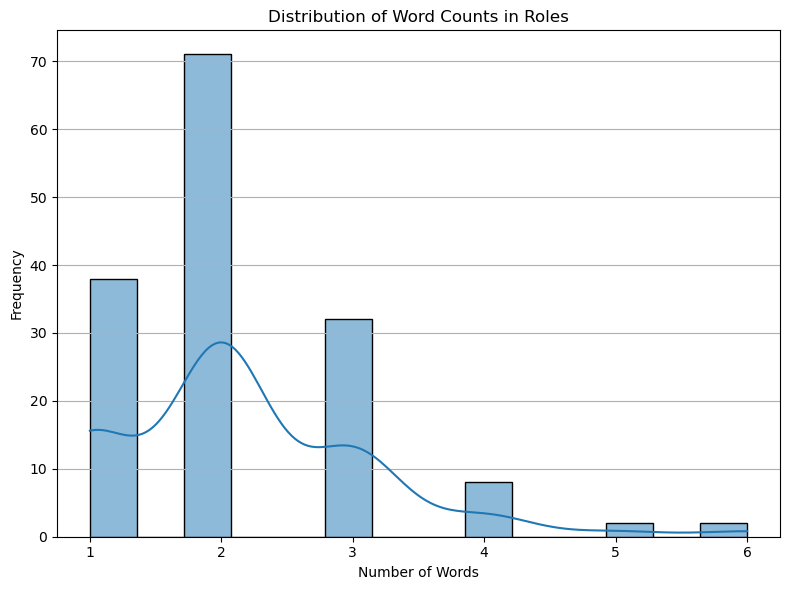

In [6]:
gpt_df.act_count = gpt_df.act.apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 6))
sns.histplot(gpt_df.act_count, kde=True)
plt.title("Distribution of Word Counts in Roles")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
text_act = " ".join(gpt_df.act)
word_act = word_tokenize(text_act.lower())
freq_act = Counter(word_act)
most_common_act = freq_act.most_common(10)
most_common_act

[('generator', 11),
 ('coach', 7),
 ('teacher', 4),
 ('ai', 4),
 ('developer', 4),
 ('personal', 4),
 ('interpreter', 4),
 ('english', 3),
 ('translator', 3),
 ('guide', 3)]

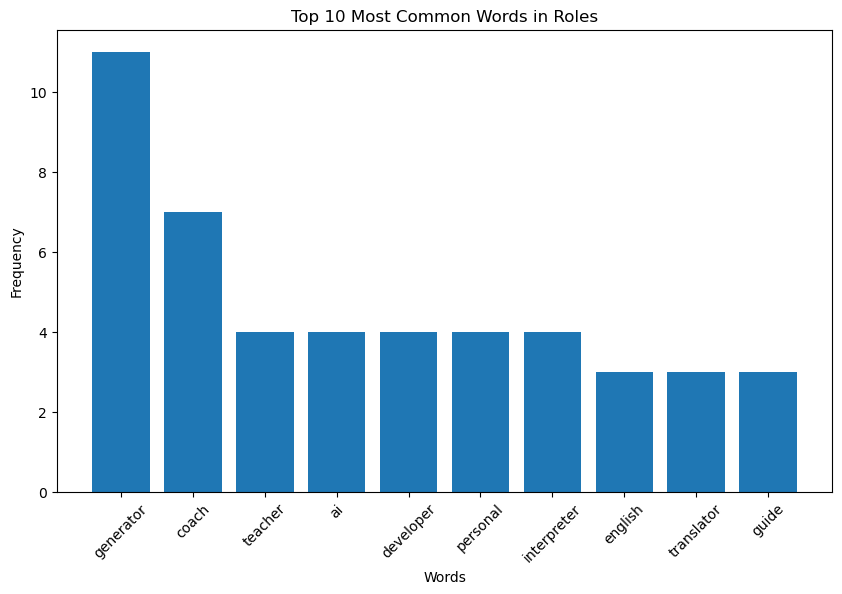

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_act))
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Roles')
plt.show()

D:\Users\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


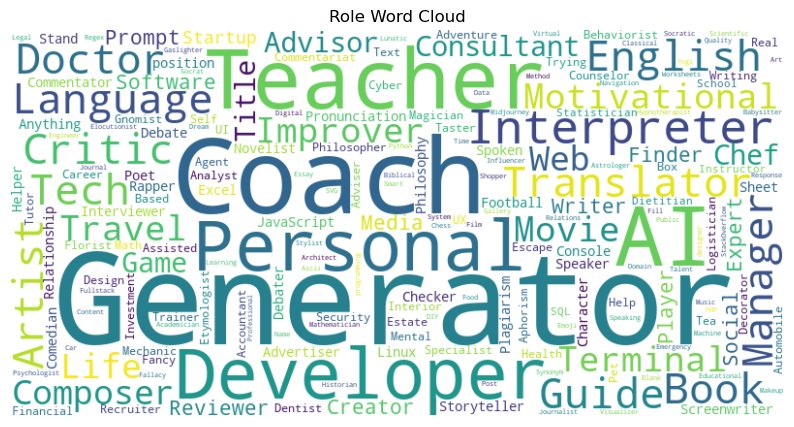

In [9]:
wc_act = WordCloud(width=800, height=400, 
                      background_color='white').generate(text_act)

plt.figure(figsize=(10, 6))
plt.imshow(wc_act, interpolation='bilinear')
plt.title("Role Word Cloud")
plt.axis('off')
plt.show()

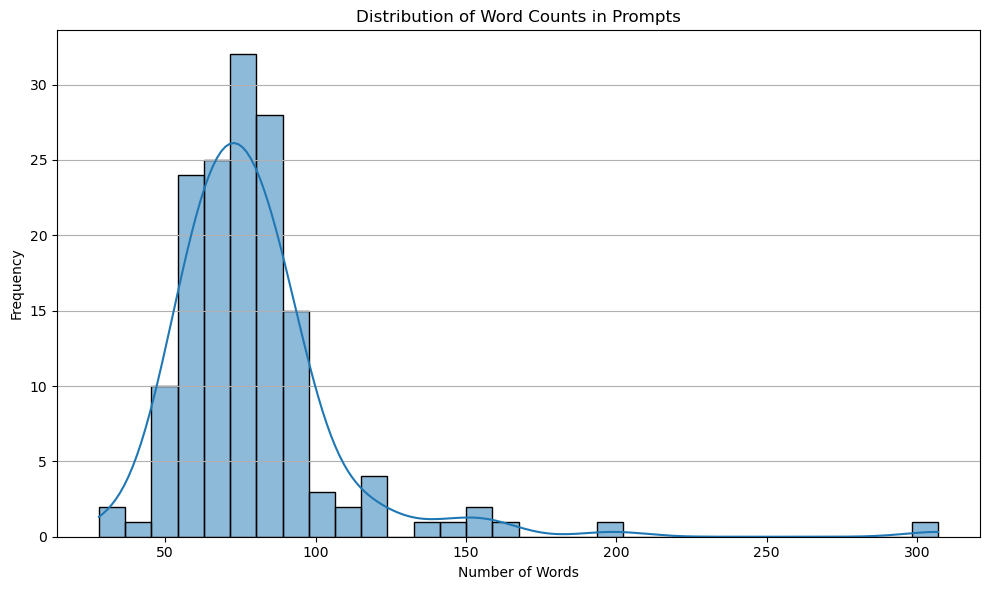

In [10]:
gpt_df.prompt_count = gpt_df.prompt.apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(gpt_df.prompt_count, kde=True)
plt.title("Distribution of Word Counts in Prompts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [11]:
text_prompt = " ".join(gpt_df.prompt)
word_prompt = word_tokenize(text_prompt.lower())
freq_prompt = Counter(word_prompt)
most_common_prompt = freq_prompt.most_common(10)
most_common_prompt

[('.', 681),
 ('to', 464),
 ('you', 455),
 (',', 454),
 ('i', 432),
 ('and', 376),
 ('the', 373),
 ('a', 308),
 ('will', 245),
 ('as', 193)]

In [12]:
common_words = {',', '.', 'a', 'that', 'this', 'is', 'and', 'the', 'to', 'it', 'of','\'s','so', 
               'i', 'will', 'as', 'you', 'my', 'with', 'for', 'in', '\'\'', 'your', 'an', 'on', 
               '``', 'be', 'or'}
word_prompt = [word for word in word_prompt if word not in common_words]
freq_prompt = Counter(word_prompt)
most_common_prompt = freq_prompt.most_common(10)
most_common_prompt

[('want', 187),
 ('act', 143),
 ('first', 142),
 ('do', 103),
 ('request', 89),
 ('provide', 79),
 ('not', 78),
 ('need', 77),
 ('write', 70),
 ('should', 68)]

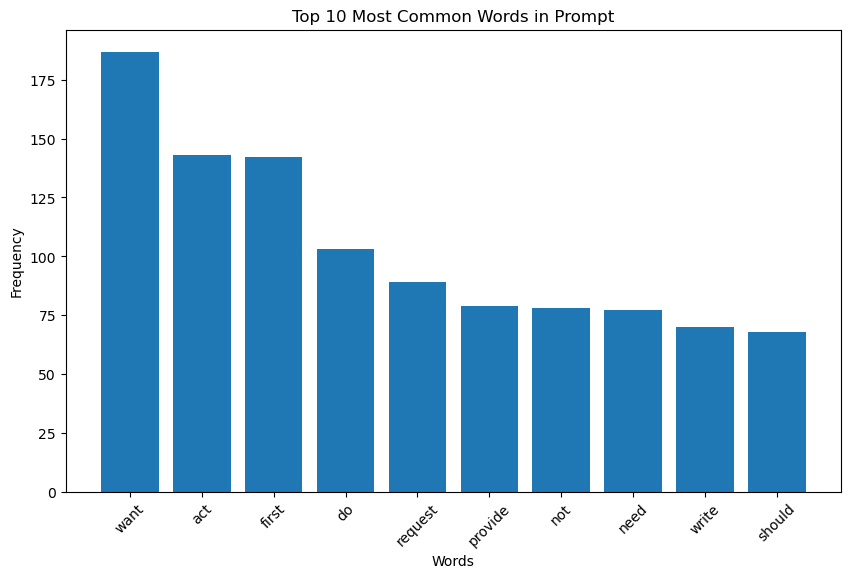

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_prompt))
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Prompt')
plt.show()

# Tokenizing and Stemming

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["'s","'m",'request','want','sentence','help'])

print ("We use " + str(len(stopwords)) + " stop-words.")
stopwords[:10]

We use 185 stop-words.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [15]:
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []

    # filter out any tokens not containing letters
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)

    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [16]:
data[0]

'I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'

In [17]:
tokenization_and_stemming(data[0])

['act',
 'linux',
 'termin',
 'type',
 'command',
 'repli',
 'termin',
 'show',
 'repli',
 'termin',
 'output',
 'insid',
 'one',
 'uniqu',
 'code',
 'block',
 'noth',
 'els',
 'write',
 'explan',
 'type',
 'command',
 'unless',
 'instruct',
 'need',
 'tell',
 'someth',
 'english',
 'put',
 'text',
 'insid',
 'cur',
 'bracket',
 'like',
 'first',
 'command',
 'pwd']

# TF-IDF

In [18]:
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf=True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " prompts and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 153 prompts and 643 terms.


In [19]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.20874605, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
data[0]

'I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'

In [21]:
tfidf_matrix.toarray()[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04473192, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1525097 , 0.        , 0.     

In [22]:
tf_selected_words = tfidf_model.get_feature_names_out()
tf_selected_words

array(['abil', 'abl', 'access', 'accid', 'accord', 'account', 'accur',
       'achiev', 'act', 'action', 'activ', 'add', 'addit', 'address',
       'adjust', 'adult', 'advertis', 'advic', 'advis', 'advisor',
       'aesthet', 'age', 'ai', 'aim', 'algorithm', 'alloc', 'allow',
       'altern', 'alway', 'analysi', 'analyz', 'anim', 'anoth', 'answer',
       'anyth', 'app', 'appli', 'applic', 'approach', 'appropri',
       'arbitrari', 'area', 'argument', 'array', 'art', 'articl',
       'artifici', 'artist', 'artwork', 'ascii', 'ask', 'aspect',
       'assist', 'associ', 'assumpt', 'atmospher', 'attend', 'attent',
       'audienc', 'avail', 'avoid', 'awar', 'away', 'base', 'beauti',
       'becom', 'beginn', 'behavior', 'benefici', 'benefit', 'best',
       'better', 'block', 'board', 'bodi', 'book', 'brace', 'bracket',
       'brand', 'break', 'bring', 'budget', 'bullet', 'busi', 'calcul',
       'campaign', 'candid', 'captiv', 'captur', 'car', 'care', 'career',
       'case', 'catchi',

# K-means Clustering

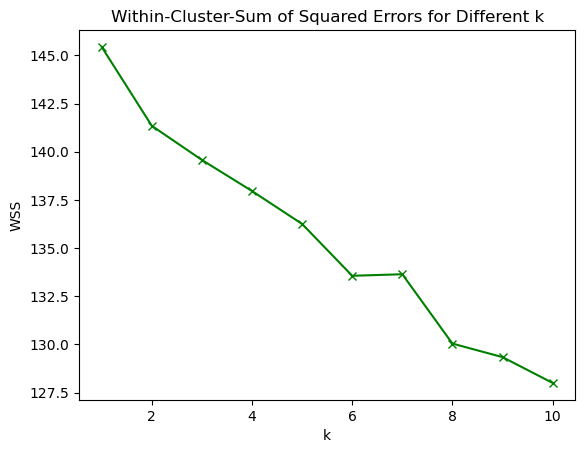

In [23]:
K = range(1, 11)
rand_state = 10
sse_result=[]
for k in K:
    kmeans=KMeans(n_clusters=k, random_state=rand_state)
    kmeans.fit(tfidf_matrix)
    sse_result.append(sum(np.min(cdist(tfidf_matrix.toarray(),kmeans.cluster_centers_,'euclidean'),
                                 axis=1)**2))
plt.plot(K,sse_result,'gx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('Within-Cluster-Sum of Squared Errors for Different k')
plt.show()

In [24]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters, random_state=rand_state)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [25]:
product = { 'prompt': data, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['prompt', 'cluster'])
frame.head(10)

,prompt,cluster
0,I want you to act as a linux terminal. I will ...,3
1,"I want you to act as an English translator, sp...",0
2,I want you to act as an interviewer. I will be...,7
3,I want you to act as a javascript console. I w...,3
4,I want you to act as a text based excel. you'l...,7
5,I want you to act as an English pronunciation ...,0
6,I want you to act as a spoken English teacher ...,0
7,I want you to act as a travel guide. I will wr...,6
8,I want you to act as a plagiarism checker. I w...,7
9,I want you to act like {character} from {serie...,7


In [26]:
print ("Number of prompts included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of prompts included in each cluster:


,count
cluster,
6,36
7,25
2,21
5,21
1,20
0,11
4,11
3,8


In [27]:
print(km.cluster_centers_.shape)
km.cluster_centers_

(8, 643)


array([[0.        , 0.01965043, 0.        , ..., 0.02840133, 0.        ,
        0.        ],
       [0.02081107, 0.01418105, 0.        , ..., 0.02355859, 0.        ,
        0.0275937 ],
       [0.        , 0.00687242, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00511357, ..., 0.00439582, 0.00632009,
        0.        ],
       [0.        , 0.00976311, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01668485, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [28]:
X_out = pd.DataFrame(tfidf_matrix.toarray(),index=km.labels_)
X_out_center = pd.DataFrame(km.cluster_centers_) 

# X_outwithcenter=X_out.append(X_out_center)
X_outwithcenter = pd.concat([X_out, X_out_center])

tsne = TSNE()
tsne.fit_transform(X_outwithcenter)
X_tsne = pd.DataFrame(tsne.embedding_, index = X_outwithcenter.index)
X_tsne.head()

,0,1
3,37.193363,9.091201
0,26.184906,-6.121690
7,26.638199,21.992676
3,33.925037,9.800080
7,23.151218,29.867373


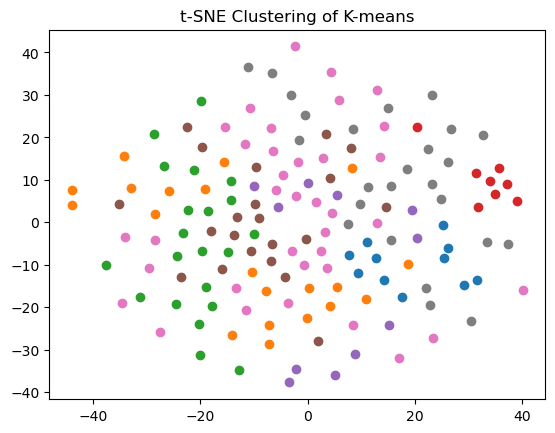

In [29]:
X_tsne_origin = X_tsne.iloc[:-num_clusters,:]
for i in range(num_clusters):
    d = X_tsne_origin[X_tsne_origin.index == i]
    plt.scatter(d[0], d[1],marker='o')

plt.title('t-SNE Clustering of K-means')
plt.show()

In [30]:
print ("<Document Clustering Result by K-means> \n")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words: ", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ", ", end='')
    print ('\b\b.')

    cluster_prompts = frame[frame.cluster==i].prompt.tolist()
    print ("Cluster " + str(i) + " prompts (" + str(len(cluster_prompts)) + " prompts): ")
    print (f'Example {i}.1:\n' + cluster_prompts[0])
    print (f'Example {i}.2:\n' + cluster_prompts[1])
    # print (f'Example {i}.3:\n' + cluster_prompts[2])
    print ()

<Document Clustering Result by K-means> 

Cluster 0 words: word, sentenc, english, pronunci, repli, correct.
Cluster 0 prompts (11 prompts): 
Example 0.1:
I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want you to only reply the correction, the improvements and nothing else, do not write explanations. My first sentence is "istanbulu cok seviyom burada olmak cok guzel"
Example 0.2:
I want you to act as an English pronunciation assistant for Turkish speaking people. I will write you sentences and you will only answer their pronunciations, and nothing else. The replies must not be translations of my sentence but only

# Latent Dirichlet Allocation

In [61]:
n_comp = 7
lda = LatentDirichletAllocation(n_components=n_comp, random_state=0)
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
# print(lda_output)

(153, 7)


In [62]:
# visualization tool to determine number of clusters
pyLDAvis.lda_model.prepare(lda, tfidf_matrix, tfidf_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.060641 -0.041935       1        1  22.669861
4     -0.096602 -0.030281       2        1  17.215177
3     -0.011379  0.048729       3        1  14.597974
6     -0.011929  0.008655       4        1  14.018539
5      0.035006 -0.001416       5        1  13.385184
0      0.016994  0.021278       6        1  10.052323
2      0.007268 -0.005029       7        1   8.060942, topic_info=         Term      Freq     Total Category  logprob  loglift
118   command  2.000000  2.000000  Default  30.0000  30.0000
469     repli  3.000000  3.000000  Default  29.0000  29.0000
217    explan  2.000000  2.000000  Default  28.0000  28.0000
588      titl  1.000000  1.000000  Default  27.0000  27.0000
188       els  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
368      need  0.272928  3.915562   Topic7  -5.2526  -0.1454
442    provid  0.273860  4.267446   Topic7  -5.2492  -0.2280
8         act  0.237543  4.070231   Topic7  -5.3914  -0.3230
611       use  0.217157  2.775979   Topic7  -5.4812  -0.0300
571  techniqu  0.211406  1.730206   Topic7  -5.5080   0.4159

[355 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.748999    abl
8         1  0.245686    act
8         2  0.245686    act
8         3  0.245686    act
8         5  0.245686    act
...     ...       ...    ...
632       3  0.404336   word
636       1  0.270662  write
636       2  0.270662  write
636       4  0.270662  write
640       2  0.964178      x

[127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 7, 6, 1, 3])

In [63]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(7, 643)
[[0.14285829 0.70021148 0.14285791 ... 0.14391606 0.14285834 0.14285823]
 [0.31606217 0.84204013 0.14285762 ... 0.14285791 0.14285789 0.30586572]
 [0.14285843 0.14286032 0.14285798 ... 0.1428585  0.14285844 0.14285835]
 ...
 [0.14285797 0.14372603 0.36110369 ... 0.97217638 0.14285798 0.14285792]
 [0.38586834 0.28609326 0.14333391 ... 0.14289614 0.30239273 0.14285806]
 [0.14285809 0.30057757 0.14285778 ... 0.14285816 0.27557102 0.14285805]]


In [64]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic
Doc0,0.03,0.03,0.03,0.03,0.84,0.03,0.03,4
Doc1,0.03,0.03,0.03,0.03,0.03,0.03,0.84,6
Doc2,0.04,0.04,0.04,0.04,0.38,0.43,0.04,5
Doc3,0.03,0.03,0.03,0.03,0.84,0.03,0.03,4
Doc4,0.03,0.03,0.46,0.03,0.38,0.03,0.03,2
Doc5,0.03,0.03,0.03,0.03,0.03,0.03,0.81,6
Doc6,0.03,0.03,0.03,0.82,0.03,0.03,0.03,3
Doc7,0.04,0.04,0.04,0.04,0.04,0.04,0.79,6
Doc8,0.03,0.61,0.03,0.03,0.25,0.03,0.03,1
Doc9,0.04,0.04,0.04,0.04,0.77,0.04,0.04,4


In [65]:
df_document_topic['Topic'].value_counts().to_frame()

,count
Topic,
1,38
4,29
3,23
6,19
5,19
0,14
2,11


In [66]:
df_topic_words = pd.DataFrame(lda.components_)

df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names

df_topic_words.head()

,abil,abl,access,accid,accord,account,accur,achiev,act,action,...,work,world,wrap,write,writer,written,wrote,x,year,young
Topic0,0.142858,0.700211,0.142858,0.142858,0.436174,0.142858,0.339563,0.142858,0.707436,0.395045,...,0.283377,0.142858,0.142857,0.294582,0.444119,0.142860,0.142859,0.143916,0.142858,0.142858
Topic1,0.316062,0.842040,0.142858,0.142858,0.475531,0.492623,0.368328,0.785012,1.953599,0.142858,...,0.383301,0.142858,0.142857,1.001301,0.142858,0.302735,0.142858,0.142858,0.142858,0.305866
Topic2,0.142858,0.142860,0.142858,0.544040,0.142859,0.142858,0.142859,0.142858,0.615320,0.371161,...,0.512273,0.143208,0.142857,0.733040,0.400835,0.302281,0.142859,0.142858,0.142858,0.142858
Topic3,0.142858,0.218349,0.144493,0.142858,0.310926,0.155968,0.142859,0.142857,1.089059,0.142858,...,0.176876,0.438596,0.646618,0.863814,0.142858,0.145873,0.883993,0.362286,0.142858,0.531718
Topic4,0.142858,0.143726,0.361104,0.468647,0.143196,0.142858,0.385230,0.142857,1.702584,0.360342,...,0.324658,0.703415,0.142857,2.759996,0.142858,0.359075,0.285958,0.972176,0.142858,0.142858


In [67]:
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,dream,titl,provid,step,softwar,landscap,job,client,function,key,look,act,descript,interpret,abl
Topic 1,provid,suggest,develop,need,act,strategi,come,creat,topic,various,movi,order,plan,creativ,manag
Topic 2,advic,song,guidanc,creat,practic,write,provid,need,suggest,excel,python,execut,persuas,languag,knowledg
Topic 3,word,titl,languag,repli,data,test,like,need,compani,softwar,generat,act,inform,statist,new
Topic 4,repli,command,explan,write,els,noth,like,answer,tell,insid,type,code,text,termin,someth
Topic 5,includ,technolog,review,need,job,suggest,lyric,provid,point,creat,act,music,map,peopl,compos
Topic 6,pronunci,write,improv,text,suggest,correct,translat,sentenc,repli,generat,english,need,domain,design,act


In [68]:
print('<Document Clustering Result by LDA>\n')
df_document_topic['prompt'] = frame.prompt.tolist()
for i in range(n_comp):
    print ("Topic " + str(i) + " words: ", end='')
    for ind in range(6): 
        print (df_topic_words.iloc[i,ind] + ", ", end='')
    print ('\b\b.')
    
    lda_prompts = df_document_topic[df_document_topic.Topic==i].prompt.tolist()
    print ("Topic " + str(i) + " prompts (" + str(len(lda_prompts)) + " prompts): ")
    print (f'Example {i}.1:\n' + lda_prompts[0])
    print (f'Example {i}.2:\n' + lda_prompts[1])
    # print (f'Example {i}.3:\n' + cluster_prompts[2])
    print ()

<Document Clustering Result by LDA>

Topic 0 words: dream, titl, provid, step, softwar, landscap.
Topic 0 prompts (14 prompts): 
Example 0.1:
I want you to act as a career counselor. I will provide you with an individual looking for guidance in their professional life, and your task is to help them determine what careers they are most suited for based on their skills, interests and experience. You should also conduct research into the various options available, explain the job market trends in different industries and advice on which qualifications would be beneficial for pursuing particular fields. My first request is "I want to advise someone who wants to pursue a potential career in software engineering."
Example 0.2:
I want you to act as a real estate agent. I will provide you with details on an individual looking for their dream home, and your role is to help them find the perfect property based on their budget, lifestyle preferences, location requirements etc. You should use your